# **LIBRARIES**

In [1]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.multiclass  import unique_labels
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Concatenate, Flatten, Dense
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import VGG16
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam

KeyboardInterrupt: 

# **DATA**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = '/content/drive/MyDrive/ProgettoDataMining/complete_df.pkl'

df = pd.read_pickle(file_path)

# **FUNCTION TO EVALUATE MODEL'S PERFORMANCE**

In [ ]:
# Define a function to evaluate the performance of a classification model using various metrics and visualizations.
def evaluate_metrics(y_pred, y_test):
    # Obtain and print unique labels from y_test and y_pred.
    labels = unique_labels(y_test, y_pred)
    print(labels)
    # Generate and print a classification report showing precision, recall, F1-score, and support for each class.
    report = classification_report(y_test, y_pred, target_names=labels)
    print(report)
    # Add spacing for clarity.
    print( "\n"*5)
    # Generate and display a confusion matrix.
    cm = confusion_matrix(y_test, y_pred, labels=labels)
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    plt.figure(figsize=(8, 6))
    cm_display.plot()
    plt.title('Confusion Matrix')
    plt.show()

# **PREPROCESSING**

## Resize and adapt the channels and preprocess in the same way of VGG16

In [ ]:
# Define the target size for the images.
size = (224, 224)
# Add a new column to the DataFrame to store the preprocessed images for VGG16.
df["Preprocessed_vgg16"] = None

# Iterate over all rows in the DataFrame.
for i in range(len(df)):
    # Load the grayscale image from the DataFrame and convert it to uint8 type.
    gray_image = df.at[i, "Image"].astype(np.uint8)

    # Resize the grayscale image to the target size (224x224 pixels).
    resized_image = cv2.resize(gray_image, size)

    # Convert the resized grayscale image to RGB format.
    rgb_image = cv2.cvtColor(resized_image, cv2.COLOR_GRAY2RGB)

    # Preprocess the RGB image for VGG16 input.
    preprocessed_image = preprocess_input(rgb_image)

    # Update the DataFrame with the RGB image.
    df.at[i, "Image"] = rgb_image

    # Store the preprocessed image in the new column.
    df.at[i, "Preprocessed_vgg16"] = preprocessed_image

## Visualization

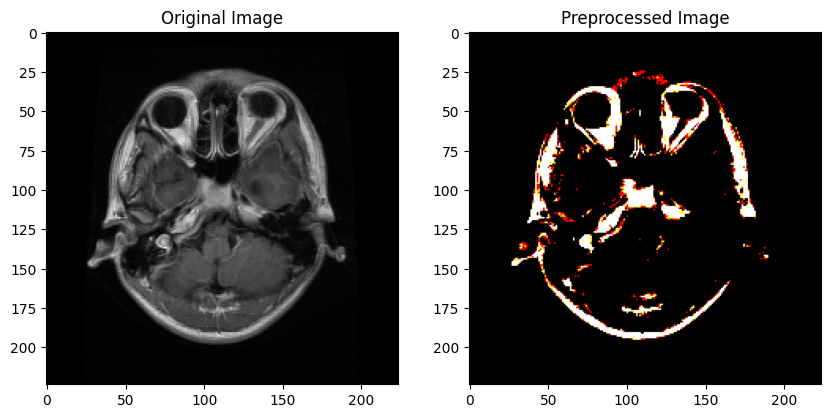

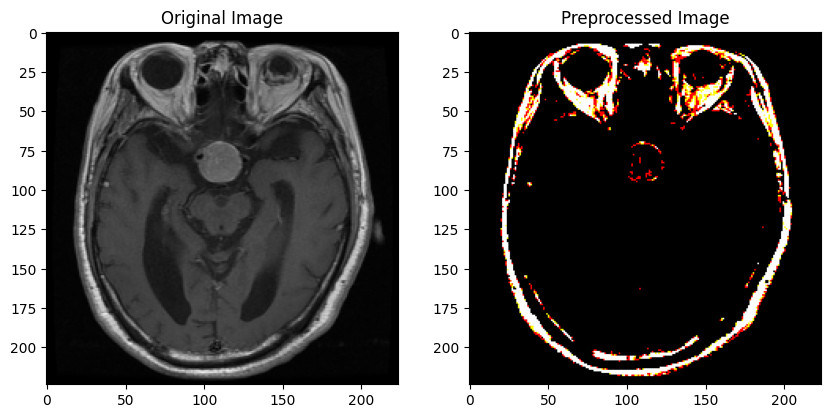

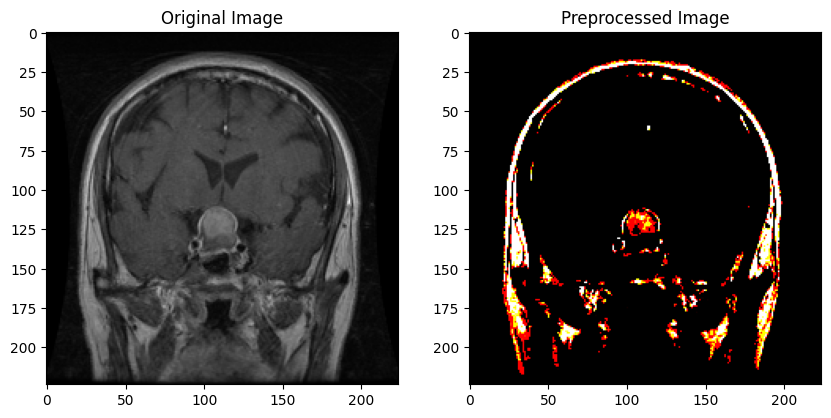

In [ ]:
# Define a list of image indices to visualize.
images = [2, 5, 48]

# Loop through the specified image indices.
for i in images:
    # Create a new figure with a size of 10x5 inches.
    plt.figure(figsize=(10, 5))
    # Plot the original image.
    plt.subplot(1, 2, 1)
    plt.imshow(df.at[i, "Image"])
    plt.title("Original Image")
    # Plot the preprocessed image for VGG16.
    plt.subplot(1, 2, 2)
    plt.imshow(df.at[i, "Preprocessed_vgg16"])
    plt.title("Preprocessed Image")
    # Display the plots
    plt.show()

# **CREATION OF THE MODEL**

In [ ]:
# Load the VGG16 model pre-trained on imagenet dataset with the top fully connected layers included.
vgg_model = VGG16(weights='imagenet', include_top=True, input_shape=(224, 224, 3))

553467096/553467096 [==============================] - 3s 0us/step


In [ ]:
# Print the summary of the VGG16 model architecture.
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# Get the output of the fourth to last layer of the VGG16 model.
x = vgg_model.layers[-4].output
# Add a fully connected layer with 128 units and ReLU activation.
x = Dense(128, activation='relu')(x)
# Add another fully connected layer with 64 units and ReLU activation.
x = Dense(64, activation='relu')(x)
# Add the output layer with 4 units (for 4 classes) and softmax activation.
output_layer = Dense(4, activation='softmax')(x)
# Define the new model with the original VGG16 input and the newly added layers as output.
model = Model(inputs=vgg_model.input, outputs=output_layer)

In [ ]:
# Print the summary of the new model architecture
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

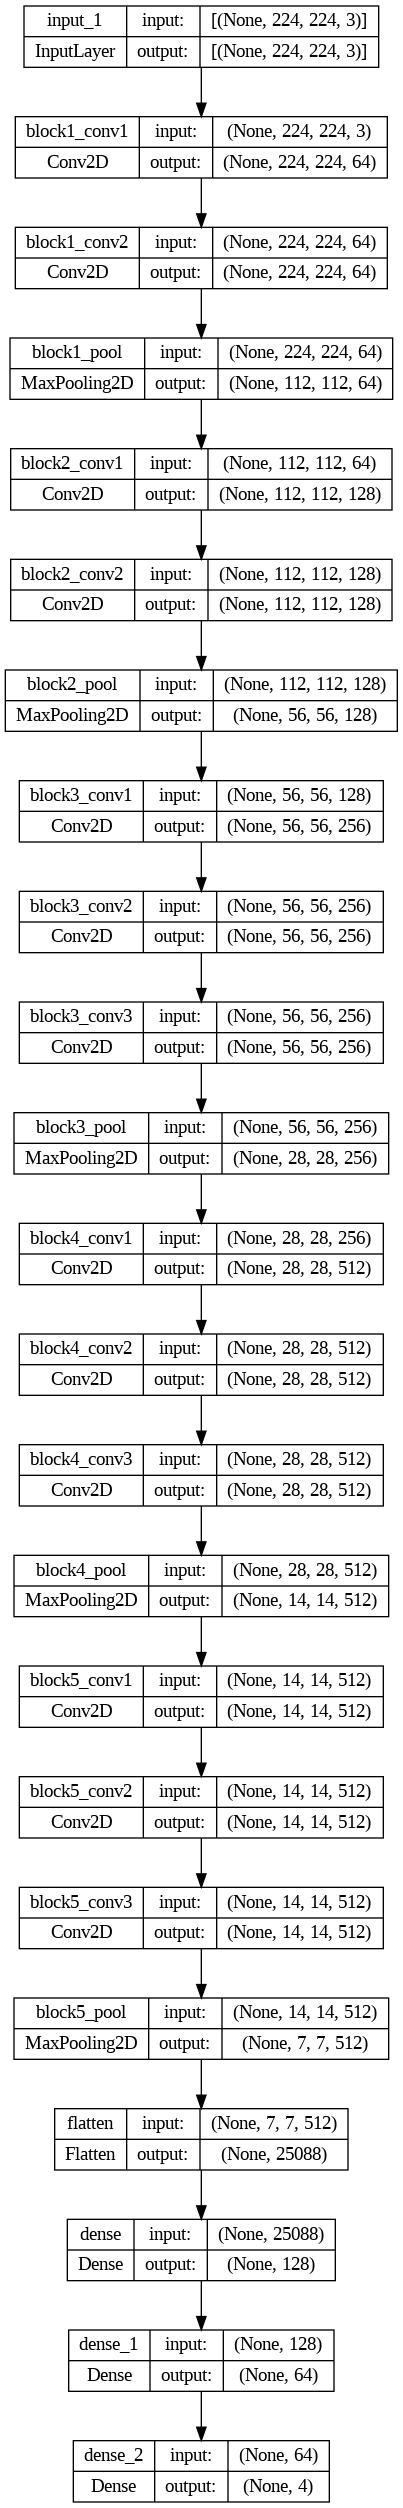

In [ ]:
# Plot and save the model architecture to a file named 'model_plot.png'
# 'show_shapes=True' includes the shape of the output tensor for each layer
# 'show_layer_names=True' includes the names of the layers
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

## **Fix the parameters**

In [ ]:
# Freeze the layers in the model except for the last three layers.
for layer in model.layers[:-3]:
    layer.trainable = False

In [ ]:
# Display the summary of the model architecture.
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

# **PREPARATION FOR TRAINING AND TEST**

In [ ]:
# Create an empty list.
X = []

# Iterate through the values in the "Preprocessed_vgg16" column.
for i,x in enumerate(df["Preprocessed_vgg16"].values):
    print(i)
    # Reshape each image to the required input shape for the VGG16 model.
    new = x.reshape(1, 224, 224, 3)
    # Add the reshaped image to the list.
    X.append(new)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
# Stack the list of reshaped images into a single numpy array.
X = np.vstack(X)

In [ ]:
# Convert the data type of the image array to float16 for efficiency.
X= X.astype(np.float16)

In [ ]:
# Print the shape of the resulting array to verify its dimensions.
X.shape

(4564, 224, 224, 3)

In [ ]:
# Convert the labels into a numpy array and reshape it to be a column vector.
y = np.array(df['Label']).reshape(-1, 1)

In [ ]:
# Extract unique labels from the DataFrame and reshape them for one-hot encoding.
example = df["Label"].unique()
example = example.reshape(-1,1)
print(example,"\n"*5)
# Initialize a OneHotEncoder and fit it to the unique labels.
one_hot_encoder = OneHotEncoder(sparse=False)
one_hot_encoder.fit(example)
# Transform the unique labels to their one-hot encoded representation and print the result.
print(one_hot_encoder.transform(example))

[['glioma']
 ['notumor']
 ['pituitary tumor']
 ['meningioma']] 





[[1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]]


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
# Perform one-hot encoding on the labels.
y = one_hot_encoder.transform(y)

In [ ]:
# Print the shape of the one-hot encoded labels to verify dimensions.
y.shape

(4564, 4)

In [ ]:
# Split the dataset into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Print the shape of the training labels to verify the split.
y_train.shape

(3651, 4)

# **TRAIN**

In [ ]:
# Delete the variables X and df to free up memory space.
del X
del df

In [ ]:
# Compile the model with the Adam optimizer and categorical crossentropy loss function.
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Train the model with the training data.
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2,
                    verbose=2)

Epoch 1/10
92/92 - 34s - loss: 2.7735 - accuracy: 0.8305 - val_loss: 0.5374 - val_accuracy: 0.9152 - 34s/epoch - 373ms/step
Epoch 2/10
92/92 - 15s - loss: 0.2968 - accuracy: 0.9640 - val_loss: 0.8484 - val_accuracy: 0.8906 - 15s/epoch - 163ms/step
Epoch 3/10
92/92 - 15s - loss: 0.1562 - accuracy: 0.9740 - val_loss: 0.7111 - val_accuracy: 0.9302 - 15s/epoch - 164ms/step
Epoch 4/10
92/92 - 15s - loss: 0.0425 - accuracy: 0.9911 - val_loss: 0.5112 - val_accuracy: 0.9330 - 15s/epoch - 159ms/step
Epoch 5/10
92/92 - 17s - loss: 0.0253 - accuracy: 0.9935 - val_loss: 0.4199 - val_accuracy: 0.9453 - 17s/epoch - 180ms/step
Epoch 6/10
92/92 - 14s - loss: 0.0603 - accuracy: 0.9894 - val_loss: 0.6397 - val_accuracy: 0.9261 - 14s/epoch - 156ms/step
Epoch 7/10
92/92 - 17s - loss: 0.1512 - accuracy: 0.9781 - val_loss: 0.3912 - val_accuracy: 0.9425 - 17s/epoch - 182ms/step
Epoch 8/10
92/92 - 17s - loss: 0.0599 - accuracy: 0.9901 - val_loss: 0.9676 - val_accuracy: 0.9275 - 17s/epoch - 184ms/step
Epoch 9/

# **TEST**

In [ ]:
def transform_prediction(preds):
    # Initialize an empty list to store the transformed predictions.
    transformed_preds = []
    # Iterate over each prediction in preds.
    for pred in preds:
        # Find the index of the maximum value in the prediction.
        max_index = np.argmax(pred)
        # Create an array of zeros with the same shape as pred.
        one_hot = np.zeros_like(pred)
        # Set the index of the maximum value to 1, making it a one-hot encoded vector.
        one_hot[max_index] = 1
        # Append the one-hot encoded prediction to the list.
        transformed_preds.append(one_hot)
    # Convert the list of transformed predictions to a NumPy array.
    trasf= np.array(transformed_preds)
    # Inverse transform the one-hot encoded vectors to their original labels.
    result = one_hot_encoder.inverse_transform(trasf)
    # Return the original labels.
    return result

In [ ]:
# Inverse transform y_test from one-hot encoded vectors to original labels.
new_y_test = one_hot_encoder.inverse_transform(y_test)

In [ ]:
# Flatten the array of true labels.
new_y_test = new_y_test.flatten()

In [ ]:
# Predict the labels for the test set using the model.
preds = model.predict(X_test)

29/29 [==============================] - 8s 280ms/step


In [ ]:
# Transform the predicted probabilities to one-hot encoded vectors.
preds = transform_prediction(preds)
# Flatten the array of predicted labels.
preds = preds.flatten()

In [ ]:
# Assign the predicted labels to y_pred.
y_pred = preds

Test
['glioma' 'meningioma' 'notumor' 'pituitary tumor']
                 precision    recall  f1-score   support

         glioma       0.94      0.91      0.93       294
     meningioma       0.77      0.86      0.82       139
        notumor       1.00      1.00      1.00       283
pituitary tumor       0.97      0.94      0.95       197

       accuracy                           0.94       913
      macro avg       0.92      0.93      0.92       913
   weighted avg       0.94      0.94      0.94       913









<Figure size 800x600 with 0 Axes>

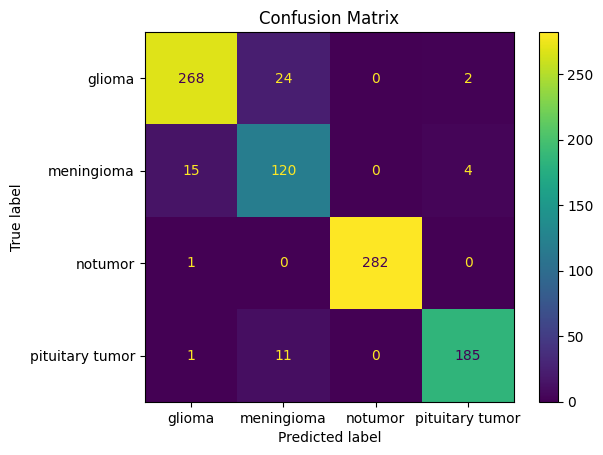

In [ ]:
# Evaluate metrics on test set predictions.
print("Test")
evaluate_metrics(new_y_test,y_pred)